In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime
sns.set(style="whitegrid", color_codes=True)
matplotlib.style.use('ggplot')

In [2]:
%matplotlib inline

In [3]:
file= r'takehome_user_engagement.csv'

In [4]:
#note: the datetime can also be converted to a format that pandas can manipulate using the to_datetime(), which returns a new
#result. it doesn't modify its argument in place, one needs to reassign it such as 
#df['x'] = pd.to_datetime(df['x'], format='%Y-%m-%d %H:%M:%SZ') 

df= pd.read_csv(file, parse_dates=['time_stamp'])
#df= pd.read_csv(file, parse_dates=['time_stamp'], index_col= 'time_stamp')

In [5]:
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
#checking total rows and columns
df.shape

(207917, 3)

In [7]:
#checking for duplicate rows in the dataset. This means no user log into the platform more than once each day
df.duplicated().sum()

0

In [8]:
#checking for null values
df.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

**Feature Engineering**

Based on requirement in the case study, a new feature needs to be engineered based on the following outcomes:
- the new variable should be called adopted user
- this user is one who logged into the product on three separate days
- this logging in event should be in at least one seven-day period

In [9]:
df.index = df['time_stamp']

In [10]:
df.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [11]:
df2 = df.drop('time_stamp', axis = 1)
df2.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


Note: You can get the same results above if you just specify the index column when reading the data in as already mentioned. I decided taking this approach so i can check for duplicates rows. I noticed making the time series the index right out of the bat provides different results compared to not having it set because duplicate checks look at the values and not the indexes.  

In [12]:
#this helps sort the datetime series
df3 = df2.groupby([pd.TimeGrouper('W'), 'user_id']).agg({'visited': np.sum})
df3.head()

visited
time_stamp user_id         
2012-06-03 563            1
           1693           1
           1995           1
           2120           1
           2136           1

In [13]:
df4 = df3.reset_index()
df4.head(10)

,time_stamp,user_id,visited
0,2012-06-03,563,1
1,2012-06-03,1693,1
2,2012-06-03,1995,1
3,2012-06-03,2120,1
4,2012-06-03,2136,1
5,2012-06-03,2494,1
6,2012-06-03,2568,1
7,2012-06-03,3428,1
8,2012-06-03,3514,1
9,2012-06-03,3721,1


In [14]:
#sorting and aggregrating by the 'user_id'
df5 = df2.groupby(['user_id', pd.TimeGrouper('D')]).agg({'visited': np.sum})
df5.head()

visited
user_id time_stamp         
1       2014-04-22        1
2       2013-11-15        1
        2013-11-29        1
        2013-12-09        1
        2013-12-25        1

In [15]:
#computing list of first day user visited
df5= df4[['time_stamp','user_id']]
df6 = df5.groupby(['user_id']).first().reset_index()
first = list(df6.loc[:,'time_stamp'])

#computing list of last day user visited
df7 = df5.groupby(['user_id']).last().reset_index()#.agg({'visited': np.sum}).first()
last = list(df7.loc[:,'time_stamp'])

#computer list of all users that visited
df8 = df5.groupby(['user_id']).count().reset_index()
usr_list = list(df8.loc[:, 'user_id'])

In [16]:
df8.head()

,user_id,time_stamp
0,1,1
1,2,11
2,3,1
3,4,1
4,5,1


In [17]:
visited = []
for n in range(len(usr_list)):
    #this meets the condition for at least 7 days and 
    if ((last[n]-first[n]) >= timedelta(7)) and (df8.loc[n, 'time_stamp'] == 3):
        visited_usr = df8.loc[n, 'user_id']
        visited.append(str(visited_usr))

In [18]:
len(visited)

271

In [19]:
print(visited)

['20', '59', '77', '142', '171', '221', '241', '277', '321', '330', '455', '479', '506', '528', '575', '608', '665', '710', '716', '736', '746', '788', '815', '1030', '1087', '1125', '1149', '1240', '1242', '1299', '1311', '1321', '1440', '1441', '1445', '1671', '1685', '1689', '1706', '1787', '1858', '1897', '1901', '1999', '2063', '2131', '2176', '2194', '2206', '2307', '2332', '2371', '2495', '2577', '2601', '2714', '2782', '2817', '2827', '2843', '2857', '2873', '2940', '2949', '2998', '3073', '3124', '3133', '3140', '3159', '3183', '3216', '3220', '3318', '3323', '3356', '3359', '3521', '3568', '3606', '3626', '3704', '3856', '3917', '4003', '4146', '4196', '4266', '4327', '4341', '4445', '4493', '4529', '4561', '4608', '4701', '4703', '4726', '4738', '4774', '4820', '4822', '4824', '4874', '4908', '4964', '5048', '5137', '5145', '5153', '5170', '5255', '5291', '5294', '5304', '5326', '5381', '5397', '5439', '5508', '5515', '5531', '5575', '5589', '5641', '5678', '5730', '5789', '

In [20]:
df9 = df.drop('time_stamp', axis =1).reset_index()

In [21]:
df9.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [22]:
#good lord :D   - https://stackoverflow.com/questions/44218378/comparison-of-a-dataframe-column-values-with-a-list
df9['adopted_user'] = df9['user_id'].isin(visited).astype(int)     

In [23]:
df9.head()

,time_stamp,user_id,visited,adopted_user
0,2014-04-22 03:53:30,1,1,0
1,2013-11-15 03:45:04,2,1,0
2,2013-11-29 03:45:04,2,1,0
3,2013-12-09 03:45:04,2,1,0
4,2013-12-25 03:45:04,2,1,0


In [24]:
df9['adopted_user'].value_counts()

0    206943
1       974
Name: adopted_user, dtype: int64

We now need to merge the DataFrame that includes the engineered feature with the second provided DataFrame to determine important feature that can predict the created adopted user. It will be using a full outer join, more like what you have in Cartesian product in SQL

In [25]:
file2= r'takehome_users.csv'

In [26]:
#df7= pd.read_csv(file2, encoding='ISO-8859-1', parse_dates=['creation_time'])
df10= pd.read_csv(file2, encoding='ISO-8859-1')


In [27]:
df10.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [28]:
df10.shape

(12000, 10)

In [29]:
#renaming object_id to user_id since they are basically the same to allow joining of the two dataframes
df10=df10.rename(columns = {'object_id':'user_id'})

In [30]:
df10.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [31]:
df10.dtypes

user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [32]:
#checking for missing values
df10.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [33]:
from sklearn.base import TransformerMixin
#this class was used to impute missing values
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with median of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill) 

In [34]:
#imputing missing values.
df11 = DataFrameImputer().fit_transform(df10)
df11.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [35]:
#showing all missing values filled in
df11.isnull().sum()

user_id                       0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

In [36]:
#merging df8 and df into one dataframe using full outer join, more like what you have in Cartesian product in SQL. 
df12 = pd.merge(df11, df9, on='user_id')

In [37]:
df12.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1,0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,1,0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,1,0
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,1,0


In [38]:
#here we see the effect of the full outer join on the size of the new DataFrame compared with its individual DataFrame 
#components.
df12.shape

(207917, 13)

In [39]:
#converting the unix timestamp of last login to datetime format in Pandas to allow uniformity and time series analysis   
df12['last_session_creation_time'] = pd.to_datetime(df12['last_session_creation_time'],unit='s')

In [40]:
df12.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,2014-04-22 03:53:30,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-15 03:45:04,1,0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-29 03:45:04,1,0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-09 03:45:04,1,0
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-25 03:45:04,1,0


Identifiers like a user ID, names and email addresses are not really good measurements or variables on an individual because they are assigned and not random. From experience, they cause unnecessary high dimensionality and overfitting. So, i am dropping them here.

In [87]:
df13 = df12.drop(['name', 'email','user_id'], axis = 1)

In [88]:
#checking for missing values
df13.isnull().sum()

creation_time                 0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
time_stamp                    0
visited                       0
adopted_user                  0
dtype: int64

In [89]:
df13.dtypes

creation_time                         object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
time_stamp                    datetime64[ns]
visited                                int64
adopted_user                           int32
dtype: object

In [90]:
df13.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user
0,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,2014-04-22 03:53:30,1,0
1,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-15 03:45:04,1,0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-29 03:45:04,1,0
3,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-09 03:45:04,1,0
4,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-25 03:45:04,1,0


In [91]:
df13.shape

(207917, 10)

In [92]:
#df10 == df13
df13['creation_time']= pd.to_datetime(df13['creation_time'])

In [93]:
#courtesy: https://stackoverflow.com/questions/37192220/convert-date-time-format-to-unix-time-stamp-pandas
df13['creation_time']= df13['creation_time'].astype(np.int64) / 10**9
df13['last_session_creation_time']= df13['last_session_creation_time'].astype(np.int64) / 10**9
df13['time_stamp']= df13['time_stamp'].astype(np.int64) / 10**9

In [94]:
df13.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user
0,1.398139e+09,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.398139e+09,1,0
1,1.384487e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.384487e+09,1,0
2,1.384487e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.385697e+09,1,0
3,1.384487e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.386561e+09,1,0
4,1.384487e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.387943e+09,1,0


**Hot coding categorical variables**

In [95]:
#selecting 2 features to hard code
some_var1 = ['creation_source']

#hot code the features
hot_code = pd.get_dummies(df13[some_var1])

#drop original variables once dummy variables have been created 
dfg = df13.drop(['creation_source'], axis=1)

#merge the created dummy variables with the original dataframe and reset the index for the overall dataframe
df14 = pd.concat([dfg, hot_code], axis=1).reset_index(drop=True)
df14.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1.398139e+09,1,0,11,10803.0,1.398139e+09,1,0,1,0,0,0,0
1,1.384487e+09,1.396238e+09,0,0,1,316.0,1.384487e+09,1,0,0,1,0,0,0
2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.385697e+09,1,0,0,1,0,0,0
3,1.384487e+09,1.396238e+09,0,0,1,316.0,1.386561e+09,1,0,0,1,0,0,0
4,1.384487e+09,1.396238e+09,0,0,1,316.0,1.387943e+09,1,0,0,1,0,0,0


In [96]:
#i dont think i need this. eyes wide shut, please :) ! THANK YOU!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#selecting the boolean features in preparation to be hot coded
#some_var2 = ['adopted_user']

#hot coding of the boolean features
#for x in some_var2:
    #df14[x] = (df14[x] == True).astype(int)

In [97]:
df14.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1.398139e+09,1,0,11,10803.0,1.398139e+09,1,0,1,0,0,0,0
1,1.384487e+09,1.396238e+09,0,0,1,316.0,1.384487e+09,1,0,0,1,0,0,0
2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.385697e+09,1,0,0,1,0,0,0
3,1.384487e+09,1.396238e+09,0,0,1,316.0,1.386561e+09,1,0,0,1,0,0,0
4,1.384487e+09,1.396238e+09,0,0,1,316.0,1.387943e+09,1,0,0,1,0,0,0


### Creating a Test Set

In [98]:
#here we are saying that we want the test data to be 20% of the full dataset, and the random_state is just setting a 
#random number generator's seed before creating the test set so that it always generates the same shuffled indices.
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df14, test_size=0.2, random_state=42)

In [99]:
train_set.shape, test_set.shape

((166333, 14), (41584, 14))

In [100]:
#we create a copy of the train data we will work with
df14_copy = train_set.copy()

In [101]:
df14_copy.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
7290,1.360250e+09,1.401463e+09,1,0,9,7787.0,1.394464e+09,1,0,0,1,0,0,0
118183,1.373583e+09,1.401923e+09,1,0,117,10398.0,1.400540e+09,1,0,0,1,0,0,0
31070,1.346944e+09,1.401894e+09,0,0,415,5954.0,1.381418e+09,1,0,0,0,0,0,1
183003,1.365736e+09,1.401765e+09,0,0,102,5954.0,1.389150e+09,1,0,0,0,0,0,1
89282,1.341657e+09,1.401878e+09,1,0,44,5954.0,1.393583e+09,1,0,0,0,0,1,0


***Creating a balanced training set***

In [102]:
df14_copy['adopted_user'].value_counts()

0    165558
1       775
Name: adopted_user, dtype: int64

We need to balance this dataset so that our model doesn't overfit to the dominant class in the labels.

In [103]:
df_majority = df14_copy[df14_copy['adopted_user'] == 0]
df_minority = df14_copy[df14_copy['adopted_user'] == 1]

In [104]:
from sklearn.utils import resample
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=165558,    # to match majority class
                                 random_state=123) # reproducible results

In [105]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [106]:
df_upsampled['adopted_user'].value_counts()

1    165558
0    165558
Name: adopted_user, dtype: int64

In [107]:
df_upsampled.shape

(331116, 14)

***Separating predictors from target variables***

In [108]:
#creating predictors and target variables for the train set
X_train = df_upsampled.drop('adopted_user', axis=1)
y_train = df_upsampled['adopted_user']

##creating predictors and target variables for the test set
df2_test_copy = test_set.copy()
X_test = df2_test_copy.drop('adopted_user', axis=1)
y_test = df2_test_copy['adopted_user']


In [109]:
X_train.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
7290,1.360250e+09,1.401463e+09,1,0,9,7787.0,1.394464e+09,1,0,1,0,0,0
118183,1.373583e+09,1.401923e+09,1,0,117,10398.0,1.400540e+09,1,0,1,0,0,0
31070,1.346944e+09,1.401894e+09,0,0,415,5954.0,1.381418e+09,1,0,0,0,0,1
183003,1.365736e+09,1.401765e+09,0,0,102,5954.0,1.389150e+09,1,0,0,0,0,1
89282,1.341657e+09,1.401878e+09,1,0,44,5954.0,1.393583e+09,1,0,0,0,1,0


In [110]:
X_test.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
178853,1.380963e+09,1.401699e+09,0,0,122,4354.0,1.386319e+09,1,0,1,0,0,0
180791,1.351500e+09,1.401871e+09,0,0,178,5954.0,1.367916e+09,1,0,0,0,1,0
23069,1.366037e+09,1.401893e+09,1,1,1,5954.0,1.398178e+09,1,0,0,1,0,0
28115,1.353649e+09,1.401861e+09,0,0,31,5954.0,1.366350e+09,1,0,0,0,0,1
1411,1.340965e+09,1.401445e+09,0,0,107,5022.0,1.379672e+09,1,1,0,0,0,0


### Building and selecting the machine learning model


In [111]:
#importing 4 different classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC

In [112]:
#instantiating 3 the classifiers 
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
#svm_clf = SVC(probability=True)

In [113]:
#aggregating the predictions of each classifier and predict the class that gets the most votes
estimators=[('lr', log_clf), ('rf', rnd_clf)]#, ('svc', svm_clf)
voting_clf = VotingClassifier(estimators, voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [114]:
all_estimators = [('lr', log_clf), ('rf', rnd_clf), ('vc', voting_clf)]#('svc', svm_clf), 

In [115]:
#let's check each classifier's accuracy on the test set.
#for some reason i was getting the error msg - AttributeError: 'LogisticRegression' object has no attribute '_class_', 
#so i switched imports to 'import sklearn.linear_model as lm' and that worked. 

from sklearn.metrics import accuracy_score
for name, clf in all_estimators:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name, accuracy_score(y_test, y_pred))

lr 0.938726433244
rf 0.998965948442
vc 0.998965948442


### Creating the model with Random Forest

In [116]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

In [117]:
# Train the classifier
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [118]:
#Print the name and gini importance of each feature
features_list = []
feature_imprt_list=[]
for feature, feature_imprt in zip(X_train.columns, rf.feature_importances_):
    features_list.append(feature)
    feature_imprt_list.append(feature_imprt)
    #print(feature)

In [119]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.01
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(rf, threshold=0.01, prefit=True) #prefit=True does exactly same as sfm.fit(train_set_tr, y_train)

In [120]:
#Print the name and gini importance of each feature
imprt_features = []
for feature_list_index in sfm.get_support(indices=True):
    if feature_list_index < len(X_train.columns):
        imprt_features.append(X_train.columns[feature_list_index])
print(imprt_features)

['creation_time', 'last_session_creation_time', 'org_id', 'invited_by_user_id', 'time_stamp']


In [121]:
feature_df = pd.DataFrame({'feature_name': features_list,'feature_imprt': feature_imprt_list})
feature_df

,feature_imprt,feature_name
0,0.302190,creation_time
1,0.491355,last_session_creation_time
2,0.004032,opted_in_to_mailing_list
3,0.004603,enabled_for_marketing_drip
4,0.045802,org_id
5,0.026995,invited_by_user_id
6,0.111907,time_stamp
7,0.000000,visited
8,0.002410,creation_source_GUEST_INVITE
9,0.002103,creation_source_ORG_INVITE


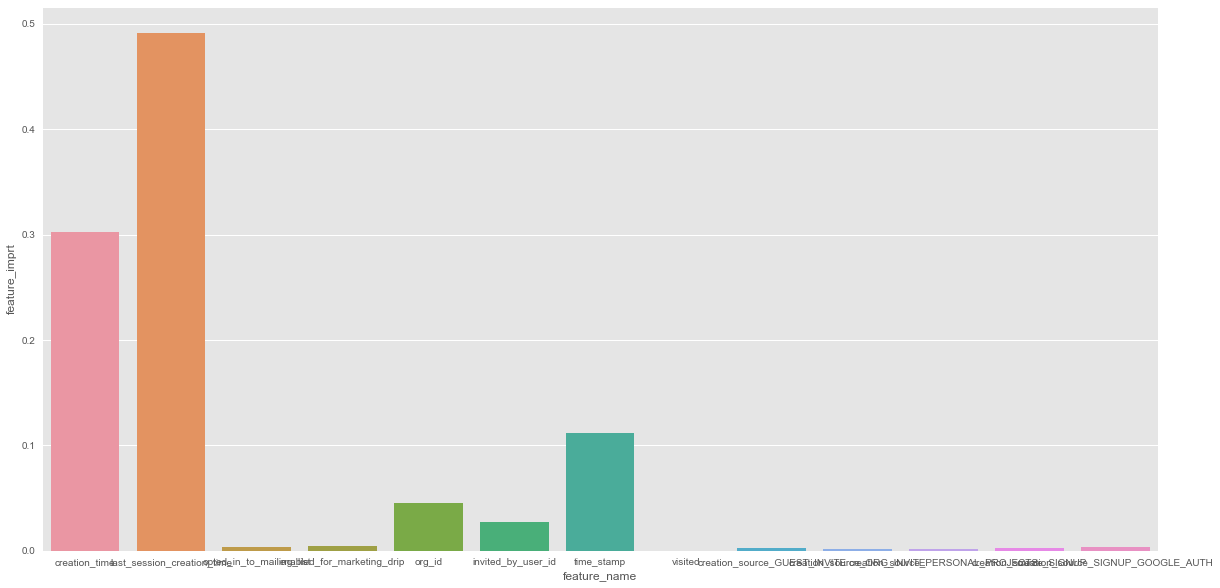

In [122]:
#plotting all features
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1,1,1)
sns.barplot(x='feature_name', y='feature_imprt', data= feature_df)
plt.show()

In [123]:
#plotting most important features
imprt_feature = feature_df[feature_df['feature_name'].isin(imprt_features)]
imprt_feature

,feature_imprt,feature_name
0,0.302190,creation_time
1,0.491355,last_session_creation_time
4,0.045802,org_id
5,0.026995,invited_by_user_id
6,0.111907,time_stamp


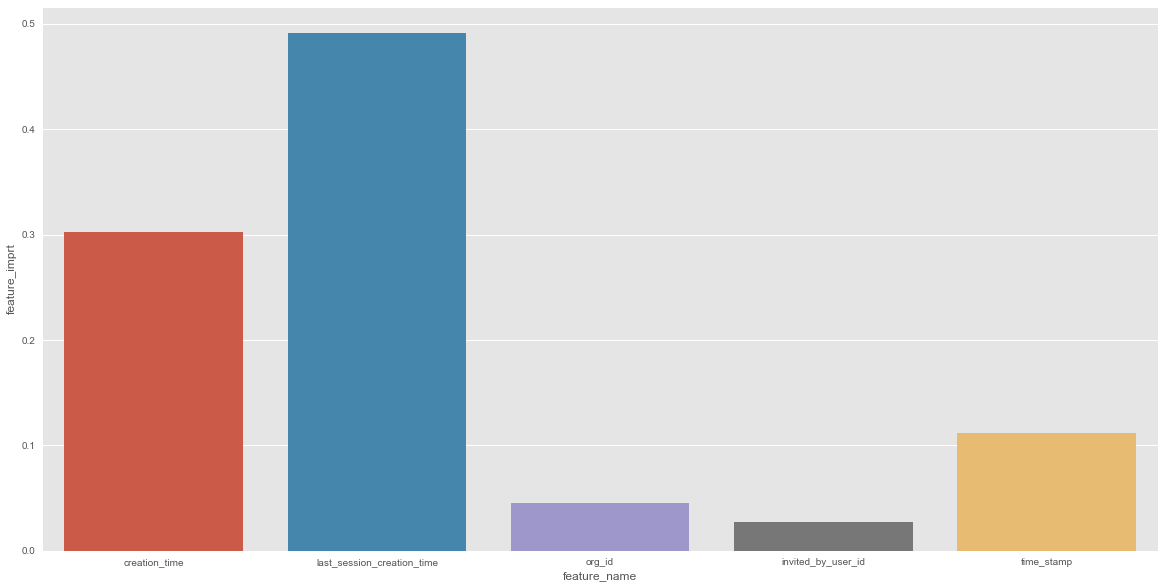

In [124]:
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1,1,1)
sns.barplot(x='feature_name', y='feature_imprt', data= imprt_feature)
plt.show()

***Creating a model with the most important features***

In [125]:
train_bal_imprt = df_upsampled.copy()[imprt_features]
train_bal_imprt.head()

,creation_time,last_session_creation_time,org_id,invited_by_user_id,time_stamp
7290,1.360250e+09,1.401463e+09,9,7787.0,1.394464e+09
118183,1.373583e+09,1.401923e+09,117,10398.0,1.400540e+09
31070,1.346944e+09,1.401894e+09,415,5954.0,1.381418e+09
183003,1.365736e+09,1.401765e+09,102,5954.0,1.389150e+09
89282,1.341657e+09,1.401878e+09,44,5954.0,1.393583e+09


In [126]:
train_bal_imprt.shape

(331116, 5)

In [127]:
train_bal_imprt.dtypes

creation_time                 float64
last_session_creation_time    float64
org_id                          int64
invited_by_user_id            float64
time_stamp                    float64
dtype: object

In [128]:
#creating predictors and target variables for the train set
X_train2 = train_bal_imprt
y_train2 = df_upsampled['adopted_user']

In [129]:
X_train2.shape, y_train.shape, X_test.shape, y_test.shape

((331116, 5), (331116,), (41584, 13), (41584,))

In [130]:
#building the model from the important features
imprt_rf = RandomForestClassifier()
imprt_rf.fit(X_train2, y_train)

#predicting the model from the important features
y_pred = rnd_clf.predict(X_test)

#printing the accuracy scores
print(accuracy_score(y_test, y_pred))


0.998965948442


### Cross-validating our Model

In [132]:
import sklearn.model_selection as ms

ms.cross_val_score(imprt_rf, X_train2, y_train, cv = ms.StratifiedKFold(shuffle = True))

array([ 0.99990034,  0.99989128,  0.99987316])

In [133]:
ms.cross_val_score(imprt_rf, X_train2, y_train, cv = ms.StratifiedKFold(shuffle = False))

array([ 0.99988222,  0.9998641 ,  0.9999094 ])

In [134]:
ms.cross_val_score(imprt_rf, X_train2, y_train, cv = ms.KFold(shuffle = True))

array([ 0.99984598,  0.99989128,  0.9998641 ])

In [135]:
ms.cross_val_score(imprt_rf, X_train2, y_train, cv = ms.KFold(shuffle = False))

array([ 0.99907585,  0.99989128,  1.        ])

### Checking for the model performance

In [136]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(confusion_mat)

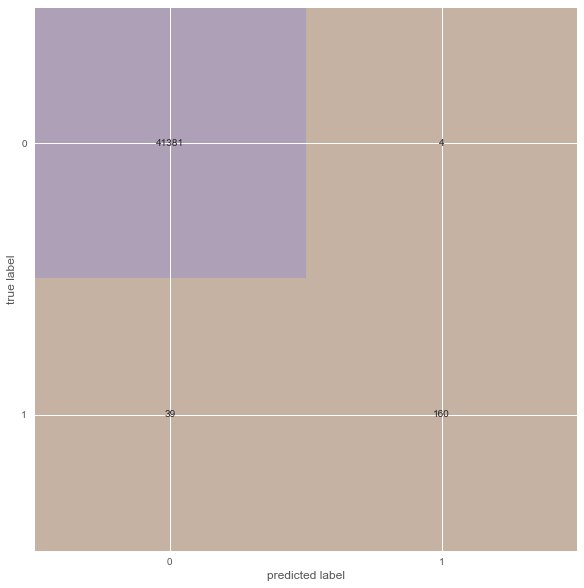

In [137]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, figsize= [10, 10], cmap='PuOr')
plt.show()

 The factors above at the 0.04 cut off mark can predict future user adoption in decreasing order of importance 

From the results above we can see that out data really generalizes well to out of sample dataset 

In [ ]:
#https://stackoverflow.com/questions/44218378/comparison-of-a-dataframe-column-values-with-a-list
#https://stackoverflow.com/questions/39594080/how-to-compare-dataframe-unique-values-with-a-list

In [ ]:
#https://stackoverflow.com/questions/4446380/python-check-the-occurrences-in-a-list-against-a-value
#df9['user_id'].astype(str).str.contains('20')
#df9['user_id'].astype(str).str.contains('77')
#df.drop('time_stamp', axis =1).reset_index().head()
#df['adopted_user'] = df['user_id'].astype(str).str.contains(user)
#df9['adpt_user'] = np.where(df9['user_id'].astype(str) == user, 'True', 'False')
#df9['adpt_user'] = np.where(df9['user_id'].astype(str) == user, 'True', 'False')